In [35]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline

print(tf.__version__)

1.9.0


In [36]:
data = input_data.read_data_sets('data/fashion',one_hot=True)

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


In [37]:
data.train.labels[0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

# Classification Helper

In [38]:
classification_dict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# Plot Sample

This is a Coat


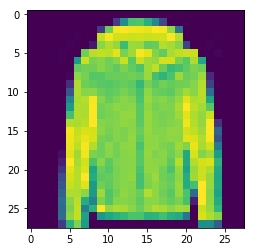

In [39]:
index = 0
image = data.train.images[index].reshape(28,28)
label = data.train.labels[index]

plt.imshow(image)

print("This is a {}".format(classification_dict[label.argmax()]))

# Formatting Data

In [40]:
x_train = data.train.images.reshape(-1, 28, 28, 1)
x_test  = data.test.images.reshape(-1,28,28,1)

y_train = data.train.labels
y_test  = data.test.labels

print('Train shape: ', x_train.shape)
print('Test shape: ', x_test.shape)

print('Train labels: ', y_train.shape)
print('Test labels: ', y_test.shape)

Train shape:  (55000, 28, 28, 1)
Test shape:  (10000, 28, 28, 1)
Train labels:  (55000, 10)
Test labels:  (10000, 10)


# Model / Forward Prop

- Conv1
- MaxPool1
- Conv2
- MaxPool2
- Flatten
- Dense1
- DenseOut

In [41]:
# This line ensures that the graph is reset every time you run this cell
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, 28,28,1]) # Taken from input shape, this represents our image input
y = tf.placeholder(tf.float32, [None, 10]) # Taken from label shape, this represents our one hot encoded label

weights = {
    'conv1': tf.get_variable('W0', shape=(3,3,1,32), initializer=tf.contrib.layers.xavier_initializer()), 
    'conv2': tf.get_variable('W1', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()), 
    'conv3': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'dense1': tf.get_variable('W3', shape=(4*4*128,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'dense2': tf.get_variable('W4', shape=(128,10), initializer=tf.contrib.layers.xavier_initializer()), 
}

biases = {
    'conv1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'conv2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'conv3': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'dense1': tf.get_variable('B3', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'dense2': tf.get_variable('B4', shape=(10), initializer=tf.contrib.layers.xavier_initializer()),
}

def conv_layer(x, W, b):
    # Convolves x with W, adds b, and activates
    conv = tf.nn.conv2d(input=x, filter=W, strides=[1, 1, 1, 1], padding="SAME")
    conv = tf.nn.bias_add(conv, b)
    return tf.nn.relu(conv)

def max_pooling(x):
    # Runs max pooling on x, reducing its size by half
    return tf.layers.max_pooling2d(x, pool_size=2, strides=2, padding="SAME")

def dense_layer(x, W, b):
    dense = tf.add(tf.matmul(x, W), b)
    return tf.nn.relu(dense)

def forward_pass(x, weights, biases):     
    c1 = conv_layer(x, weights['conv1'], biases['conv1'])
    c1 = max_pooling(c1) # Chooses the max value from a 2*2 matrix window and outputs a 14*14 matrix (28x28/2 = 14x14)
    
    print(tf.shape(c1))
    
    c2 = conv_layer(c1, weights['conv2'], biases['conv2'])
    c2 = max_pooling(c2) # Reduces image again by half (14x14/2 = 7x7)
    
    print(tf.shape(c2))
                                
    c3 = conv_layer(c2, weights['conv3'], biases['conv3'])
    c3 = max_pooling(c3) # Reduces image again by half (tf rounds up with padding same, so 7/2 = ceil(3.5) = 4) (7x7/2 = 4x4)
            
    flattened = tf.reshape(c3, [-1, 4*4*128]) # 2048
    
    dense1 = dense_layer(flattened, weights['dense1'], biases['dense1'])

    # Dense without activation
    predictions = tf.add(tf.matmul(dense1, weights['dense2']), biases['dense2'])
    
    return predictions

## Backprop

Now that we've defined our forward pass, there are 4 elements in our training...

1. Get predictions by doing a forward pass
2. Define loss (difference between labels and predictions)
3. Define optimizer
4. Use optimizer to minimize loss

In [42]:
# Do a forward pass of our training data
y_predictions = forward_pass(x, weights, biases) # x = placeholder for image

# Define our loss (difference between labels and predictions)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_predictions, labels=y)) # y = placeholder for true labels

# Define how we're going to optimise our loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

# Define our single pass of forward and back prop (user optimiser to minimise loss)
train = optimizer.minimize(loss)

Tensor("Shape:0", shape=(4,), dtype=int32)
Tensor("Shape_1:0", shape=(4,), dtype=int32)


In [43]:
# Make some nodes that tell us if we got it right when computed
correct_prediction = tf.equal(tf.argmax(y_predictions, 1), tf.argmax(y, 1))

# Node for accuracy across all examples
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [44]:
init            = tf.global_variables_initializer()
steps           = 50
batch_size      = 50
n_samples = len(data.train.images)
training_loss   = []
training_acc    = []
testing_loss   = []
testing_acc    = []

with tf.Session() as sess:
    sess.run(init)    
    
    for step in range(steps):
        for batch in range(int(n_samples/batch_size)):
            x_batch = data.train.images[batch*batch_size : (1+batch)*batch_size]
            y_batch = data.train.labels[batch*batch_size : (1+batch)*batch_size]
            
            x_batch = x_batch.reshape(-1, 28, 28, 1)
        
            sess.run(train, feed_dict={x: x_batch, y: y_batch})

        ### TRAIN
        # Calc training loss and accuracy... (note to use different variable names or python will try to reassign)
        train_loss_val, train_acc = sess.run([loss, accuracy], feed_dict={x: x_batch, y: y_batch})
        
        training_loss.append(train_loss_val)
        training_acc.append(train_acc)
        
        print("STEP: {} TRAIN LOSS: {} TRAIN ACCURACY: {}%".format(step, train_loss_val, train_acc))
        
        ### TEST
        # Set up test dataset
        x_test = data.test.images.reshape(-1, 28, 28, 1)
        y_test = data.test.labels
        
        # Calc training loss and accuracy... (note to use different variable names or python will try to reassign)
        test_loss_val, test_acc = sess.run([loss, accuracy], feed_dict={x: x_test, y: y_test})
        
        testing_loss.append(test_loss_val)
        testing_acc.append(test_acc)
        
        print("STEP: {} TEST LOSS: {} TEST ACCURACY: {}%".format(step, test_loss_val, test_acc))

STEP: 0 TRAIN LOSS: 0.3385242223739624 TRAIN ACCURACY: 0.8999999761581421%
STEP: 0 TEST LOSS: 0.3754064738750458 TEST ACCURACY: 0.8640999794006348%
STEP: 1 TRAIN LOSS: 0.25302237272262573 TRAIN ACCURACY: 0.8999999761581421%
STEP: 1 TEST LOSS: 0.31997308135032654 TEST ACCURACY: 0.888700008392334%
STEP: 2 TRAIN LOSS: 0.2127353996038437 TRAIN ACCURACY: 0.9399999976158142%
STEP: 2 TEST LOSS: 0.2972147464752197 TEST ACCURACY: 0.8934999704360962%
STEP: 3 TRAIN LOSS: 0.20761917531490326 TRAIN ACCURACY: 0.9399999976158142%
STEP: 3 TEST LOSS: 0.29925981163978577 TEST ACCURACY: 0.8902000188827515%
STEP: 4 TRAIN LOSS: 0.16457563638687134 TRAIN ACCURACY: 0.9399999976158142%
STEP: 4 TEST LOSS: 0.28317636251449585 TEST ACCURACY: 0.8984000086784363%
STEP: 5 TRAIN LOSS: 0.12959697842597961 TRAIN ACCURACY: 0.9599999785423279%
STEP: 5 TEST LOSS: 0.2921101748943329 TEST ACCURACY: 0.8953999876976013%
STEP: 6 TRAIN LOSS: 0.09738635271787643 TRAIN ACCURACY: 0.9599999785423279%
STEP: 6 TEST LOSS: 0.294664889

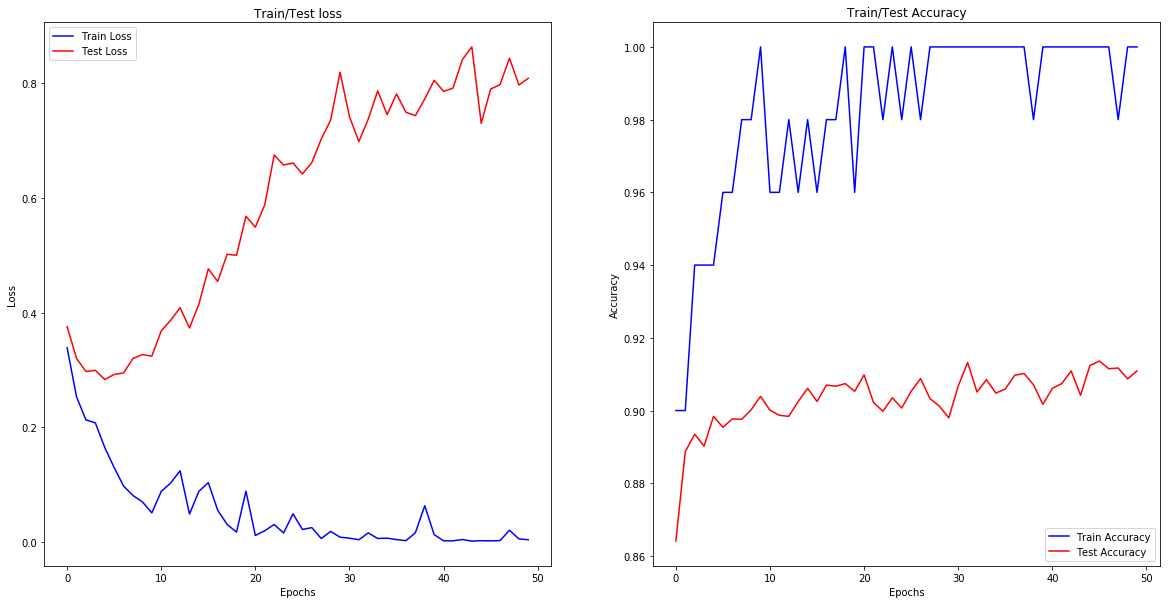

In [46]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.plot(range(steps), training_loss, 'b', label="Train Loss")
ax1.plot(range(steps), testing_loss, 'r', label="Test Loss")
ax1.set_title("Train/Test loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()
         
ax2.plot(range(steps), training_acc, 'b', label="Train Accuracy")
ax2.plot(range(steps), testing_acc, 'r', label="Test Accuracy")
ax2.set_title("Train/Test Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

In [49]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    save_path = saver.save(sess, "./model.ckpt")
    print("Model saved in path: {}".format(save_path))

Model saved in path: ./model.ckpt
